# Choosing blocking rules to optimise runtime


To link records, we need to compare pairs of records, and decide which pairs are matches and non matches.

For most large datasets, it is computationally intractable to compare every row with every other row, since the number of comparisons rises quadratically with the number of records.  

Instead we rely on blocking rules, which specify which pairwise comparisons to generate.  For example, we could generate the subset of pairwise comparisons where either first name or surname matches.

This is part of a two step process to link data:

1.  Use blocking rules to generate candidate pairwise record comparisons

2.  Use a probabilistic linkage model to score these candidate pairs, to determine which ones should be linked

**Blocking rules are the most important determinant of the performance of your linkage job**.  

When deciding on your blocking rules, you're trading off accuracy for performance:

- If your rules are too loose, your linkage job may fail.  
- If they're too tight, you may miss some valid links. 

This tutorial clarifies what blocking rules are, and how to choose good rules.


## Blocking rules in Splink

In Splink, blocking rules are specified as SQL expressions. 

For example, to generate the subset of record comparisons where the first name matches, we can specify the following blocking rule:

`l.first_name = r.first_name`

Since blocking rules are SQL expressions, they can be arbitrarily complex.  For example, you could create record comparisons where the initial of the first name and the surname match with the following rule:

`substr(l.first_name, 1,1) = substr(r.first_name, 1,1) and l.surname = r.surname`



## Devising effective blocking rules 


The aims of your blocking rules are twofold:
1. Eliminate enough non-matching comparison pairs so your record linkage job is small enough to compute
2. Eliminate as few truly matching pairs as possible (ideally none)

It is usually impossible to find a single blocking rule which achieves both aims, so we recommend using multiple blocking rules.  

When we specify multiple blocking rules, Splink will generate all comparison pairs that meet any one of the rules.

For example, consider the following blocking rule:

`l.first_name = r.first_name and l.dob = r.dob`

This rule is likely to be effective in reducing the number of comparison pairs.  It will retain all truly matching pairs, except those with errors or nulls in either the `first_name` or `dob` fields.

Now consider a second blocking rule:

`l.email and r.email`.

This will retain all truly matching pairs, except those with errors or nulls in the `email` column.


Individually, these blocking rules are problematic because they exclude true matches where the records contain typos of certain types.  But between them, they might do quite a good job.  

For a true match to be eliminated by the use of these two blocking rules, it would have to have an error in _both_  email AND (first name or date of birth).  

This is not completely implausible, but it is significantly less likely than if we'd just used a single rule.

More generally, we can often specify multiple blocking rules such that it becomes highly implausible that a true match would not meet at least one of these blocking critera.  This is the recommended approach in Splink.  Generally we would recommend between about 3 and 10, though even more is possible.

The question then becomes how to choose what to put in this list.


## Splink tools to help choose your blocking rules

Splink contains a number of tools to help you choose effective blocking rules.  Let's try them out, using our small test dataset:

In [1]:
import pandas as pd 
import altair as alt
alt.renderers.enable('mimetype')

df = pd.read_csv("./data/fake_1000.csv")

### Counting the number of comparisons created by a single blocking rule

On large datasets, some blocking rules imply the creation of trillions of record comparisons, which would cause a linkage job to fail.

Before using a blocking rule in a linkage job, it's therefore a good idea to count the number of records it generates to ensure it is not too loose:



In [2]:
from splink.duckdb.duckdb_linker import DuckDBLinker
settings = {"link_type": "dedupe_only"}
linker = DuckDBLinker(df, settings)

blocking_rule_1 = "substr(l.first_name,1,1) = substr(r.first_name,1,1) and l.surname = r.surname"
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_1)
print(f"Number of comparisons generated by '{blocking_rule_1}': {count:,.0f}")

blocking_rule_2 = "l.surname = r.surname"
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_2)
print(f"Number of comparisons generated by '{blocking_rule_2}': {count:,.0f}")

blocking_rule_3 = "l.email = r.email"
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_3)
print(f"Number of comparisons generated by '{blocking_rule_3}': {count:,.0f}")

blocking_rule_3 = "l.city = r.city and l.first_name = r.first_name"
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_3)
print(f"Number of comparisons generated by '{blocking_rule_3}': {count:,.0f}")


Number of comparisons generated by 'substr(l.first_name,1,1) = substr(r.first_name,1,1) and l.surname = r.surname': 473
Number of comparisons generated by 'l.surname = r.surname': 1,638
Number of comparisons generated by 'l.email = r.email': 682
Number of comparisons generated by 'l.city = r.city and l.first_name = r.first_name': 315


The maximum number of comparisons that you can compute will be affected by your choice of SQL backend, and how powerful your computer is.

For linkages in DuckDB on a standard laptop, we suggest using blocking rules that create no more than about 20 million comparisons.  For Spark and Athena, try starting with fewer than a a billion comparisons, before scaling up.

### Counting the number of comparisons created by a list of blocking rules

As noted above, it's usually a good idea to use multiple blocking rules.  It's therefore useful to know how many record comparisons will be generated when these rules are applied.

Since the same record comparison may be created by several blocking rules, and Splink automatically deduplicates these comparisons, we cannot simply total the number of comparisons generated by each rule individually.  

Splink provides a chart that shows the marginal (additional) comparisons generated by each blocking rule, after deduplication:


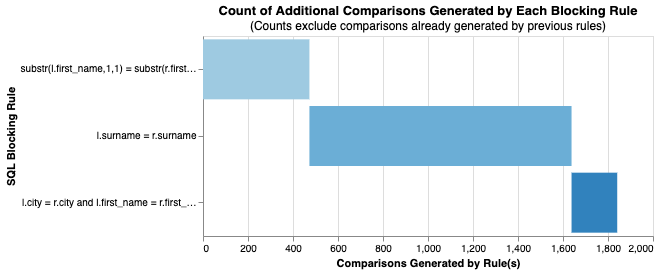

In [3]:
blocking_rules = [blocking_rule_1, blocking_rule_2, blocking_rule_3]
linker.cumulative_num_comparisons_from_blocking_rules_chart(blocking_rules)

### Understanding why certain blocking rules create large numbers of comparisons

Finally, we can use the `profile_columns` function we saw in the previous tutorial to understand a specific blocking rule in more depth.

Suppose we're interested in blocking on city and first initial.  

Within each distinct value of `(city, first initial)`, all possible pairwise comparisons will be generated.

So for instance, if there are 15 distinct records with `London,J` then these records will result in `n(n-1)/2 = 105` pairwise comparisons being generated.

In a larger dataset, we might observe 10,000 `London,J` records, which would then be responsible for `49,995,000` comparisons.  

These high-frequency values therefore have a disproportionate influence on the overall number of pairwise comparisons, and so it can be useful to analyse skew, as follows:

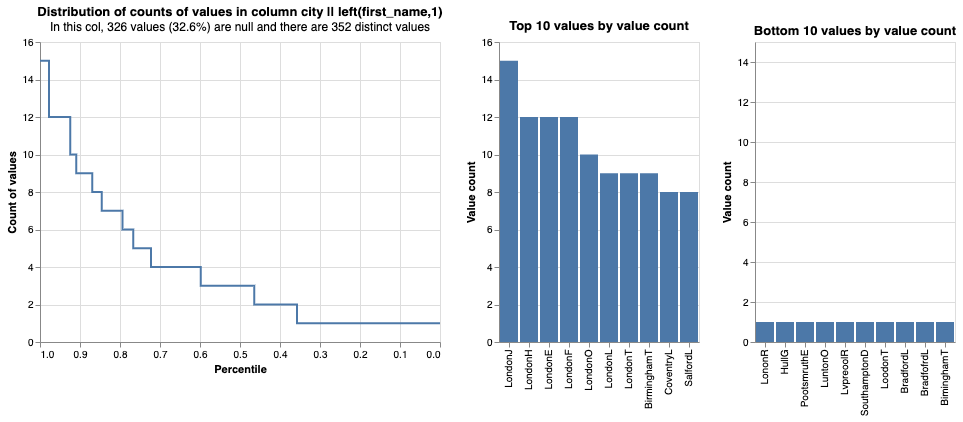

In [4]:
linker.profile_columns("city || left(first_name,1) ")